<div style="nosxt-align:cennosr; font-size:26px; color:green;">Indicadores de Riesgo</div>

Si no compartimos el conocimiento no sirve para nada. [Michio Kaku](https://www.younuestrobe.com/watch?v=6rDxlolYUQw)

**Descarga de cotizaciones.**  
Para obtener datos históricos de precios, puedes:

Descargarlos directamente desde las gestoras de los fondos.
Utilizar plataformas públicas como Yahoo Finance mediante la librería yfinance.
yfinance es una herramienta popular en análisis financiero que facilita el acceso a datos históricos considerados de dominio público. Sin embargo, estos datos pueden presentar pequeñas diferencias con respecto a las fuentes oficiales. Por ello, para decisiones críticas, siempre se recomienda contrastar la información con la documentación oficial de la gestora.

⚠️ **Precauciones.**
Este proyecto utiliza yfinance (con licencia bajo la [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).
), una interfaz para descargar datos financieros desde Yahoo Finance. Ten en cuenta lo siguiente:

Los datos descargados son exclusivamente para uso personal.
No está permitido redistribuirlos o venderlos.
Su uso en contextos educativos o sin ánimo de lucro suele ser aceptable, siempre que se cumplan estas condiciones.
Evita realizar peticiones excesivas o abusivas que puedan violar los términos de uso del servicio.



# Calcular indicadores de riesgo

## Importar quotes

In [ ]:
import os
import pandas as pd
import yfinance as yf
from typing import Tuple, Optional, Dict
from pathlib import Path
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

class Importarquotes:
    def __init__(self, directory_paths: dict = None, rfr: float = 0.02):
        """
        Inicializa la clase Importarquotes.

        Args:
            directory_paths (dict, optional): Diccionario con las rutas de los directorios para diferentes fuentes de datos.
            Ejemplo: {'yf': '/path/to/yf', 'r4': '/path/to/r4', 'investing': '/path/to/investing'}.

            rfr (float, optional): Tasa libre de riesgo. Defaults to 0.02 (2%).
        """
        self.directory_paths = directory_paths or {}
        self.rfr = rfr
        self.value_closures = None
        self.value_closures = None
        self.benchmark_closures = None
        self.ticker = None
        self.benchmark = None
        self.start_date = None
        self.end_date = None
        self.value_returns = None
        self.benchmark_returns = None
        self.value_closures = None
        self.benchmark_value_closures = None

    def list_csv_files(self, directory_path: str) -> Optional[str]:
        """Lista los archivos CSV en el directorio y permite seleccionar uno."""
        try:
            files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
            if not files:
                print("No hay archivos CSV disponibles en el directorio.")
                return None

            print("Archivos CSV disponibles:")
            for i, file in enumerate(files, 1):
                print(f"{i}. {file}")

            while True:
                try:
                    choice = int(input("Selecciona un archivo (o 0 para salir): "))
                    if choice == 0:
                        return None
                    if 1 <= choice <= len(files):
                        return files[choice - 1]
                    print("Opción inválida. Intenta de nuevo.")
                except ValueError:
                    print("Por favor, ingresa un número válido.")
        except FileNotFoundError:
            print(f"Directorio no encontrado: {directory_path}")
            return None

    def import_csv(self, tipo_archivo: str) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """Importa un archivo CSV dependiendo del tipo especificado."""
        directory_path = self.directory_paths.get(tipo_archivo)
        if not directory_path:
            print(f"Tipo de archivo '{tipo_archivo}' no soportado o directorio no configurado.")
            return None, None

        archivo_seleccionado = self.list_csv_files(directory_path)
        if not archivo_seleccionado:
            print("No se seleccionó ningún archivo.")
            return None, None

        full_path = Path(directory_path) / archivo_seleccionado

        if not full_path.is_file():
            print(f"El archivo {full_path} no existe.")
            return None, None

        try:
            if tipo_archivo == 'yf':
                df = pd.read_csv(full_path, parse_dates=['Date'], index_col='Date')
            elif tipo_archivo == 'r4':
                df = pd.read_csv(full_path, delim_whitespace=True, names=['Date', 'Close'], decimal=",", skiprows=1)
                df['Date'] = pd.to_datetime(df['Date'].str.replace("'", ""), format='%d/%m/%Y', errors='coerce')
                df.set_index('Date', inplace=True)
            elif tipo_archivo == 'investing':
                df = pd.read_csv(full_path)
                df.columns = df.columns.str.strip()
                df.rename(columns={'Fecha': 'Date', 'Último': 'Close'}, inplace=True)
                df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
                df.set_index('Date', inplace=True)
                df['Close'] = df['Close'].str.replace('.', '').str.replace(',', '.').astype(float)
            else:
                raise ValueError("Tipo de archivo no soportado.")

            df.index = pd.to_datetime(df.index)
            value_closures = df[['Close']]
            return df, value_closures

        except Exception as e:
            print(f"Error al leer el archivo '{archivo_seleccionado}': {str(e)}")
            return None, None

    def importar_de_yf(self, ticker: str) -> Tuple[Optional[pd.DataFrame], Optional[pd.Series]]:
        """Descarga los datos de un ticker directamente de Yahoo Finance."""
        try:
            # Descargar datos de Yahoo Finance
            df = yf.download(ticker, start=self.start_date, end=self.end_date)

            # Verificar si el value_closures tiene un MultiIndex en las columnas
            if isinstance(df.columns, pd.MultiIndex):
                # Seleccionar solo las columnas correspondientes al ticker
                df = df.loc[:, (slice(None), ticker)]
                # Eliminar el nivel innecesario del MultiIndex
                df.columns = df.columns.droplevel(1)

            # Verificar si el value_closures está vacío
            if len(df) == 0:
                print(f"No se encontraron datos para {ticker}")
                return None, None

            # Calcular los retornos diarios
            returns = df['Close'].pct_change().dropna()

            # Devolver el value_closures y los retornos
            return df, returns

        except Exception as e:
            print(f"Error al cargar los datos: {str(e)}")
            return None, None

    def _calculate_returns(self, df: pd.DataFrame) -> pd.Series:
        """Calcula los retornos diarios a partir de los precios de cierre."""
        return df['Close'].pct_change().dropna()

    def filtrar_datos_por_fecha(self, df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
        """Filtra los datos por un rango de fechas."""
        try:
            start_date = pd.to_datetime(start_date)
            end_date = pd.to_datetime(end_date)
            mask = (df.index >= start_date) & (df.index <= end_date)
            filtered_df = df.loc[mask]
            return filtered_df
        except Exception as e:
            print(f"Error al filtrar datos: {str(e)}")
            return df

    def importar_csv_y_filtrar(self, tipo_archivo: str) -> Tuple[Optional[pd.DataFrame], Optional[pd.Series]]:
        """Importa datos de un archivo CSV y los filtra por fecha."""
        df, value_closures = self.import_csv(tipo_archivo)
        if df is None or value_closures is None:
            return None, None

        print(f"Datos importados desde {tipo_archivo}.")
        print(f"Rango de fechas disponible: {df.index[0].strftime('%Y-%m-%d')} a {df.index[-1].strftime('%Y-%m-%d')}")

        filtered_df = self.filtrar_datos_por_fecha(df, self.start_date, self.end_date)
        if len(filtered_df) == 0:
            print("No hay datos disponibles para el rango de fechas especificado.")
            return None, None

        returns = self._calculate_returns(filtered_df)

        print(f"Datos filtrados correctamente.")
        print(f"Período: {filtered_df.index[0].strftime('%Y-%m-%d')} a {filtered_df.index[-1].strftime('%Y-%m-%d')}")
        print(f"Total de {len(filtered_df)} días de mercado")

        return filtered_df, returns

    def preparar_datos_para_risk_analyzer(self) -> Dict:
        """
        Prepara los datos para ser utilizados con la clase RiskAnalyzer.

        Returns:
            Dict: Un diccionario con los value_closuress y Series requeridos para RiskAnalyzer:
                - cierres_valor: value_closures con solo los precios de cierre del valor
                - datos_completos_valor: value_closures con todos los datos del valor
                - cierres_benchmark: value_closures con solo los precios de cierre del benchmark
                - retornos_valor: Serie con los retornos del valor
                - retornos_benchmark: Serie con los retornos del benchmark
        """
        if self.value_closures is None:
            print("Error: No hay datos cargados para el valor principal.")
            return None

        # Preparar datos del valor principal
        cierres_valor = self.value_closures[['Close']] if 'Close' in self.value_closures.columns else None
        datos_completos_valor = self.value_closures
        retornos_valor = self.value_returns

        # Preparar datos del benchmark (si existe)
        cierres_benchmark = None
        retornos_benchmark = None

        if self.benchmark_value_closures is not None:
            cierres_benchmark = self.benchmark_value_closures[['Close']] if 'Close' in self.benchmark_value_closures.columns else None
            retornos_benchmark = self.benchmark_returns

        # Verificar datos mínimos necesarios
        if cierres_valor is None or retornos_valor is None:
            print("Error: Faltan datos esenciales para el análisis de riesgo.")
            return None

        # Crear diccionario con los datos
        risk_value_closures = {
            'cierres_valor': cierres_valor,
            'datos_completos_valor': datos_completos_valor,
            'cierres_benchmark': cierres_benchmark,
            'retornos_valor': retornos_valor,
            'retornos_benchmark': retornos_benchmark
        }

        print("Datos preparados correctamente para análisis de riesgo.")
        return risk_value_closures


def seleccionar_fuente_datos(mensaje: str,quotes: Importarquotes):
    """Función para seleccionar la fuente de datos y cargar los datos."""
    while True:
        print(f"\n{mensaje}:")
        print("1. Yahoo Finance (descarga directa)")
        print("2. Archivo CSV de R4")
        print("3. Archivo CSV de Investing")
        print("0. Salir")

        try:
            opcion = int(input("Opción: "))

            if opcion == 0:
                return None, None, None

            elif opcion == 1:  # Yahoo Finance
                ticker = input("Introduce el ticker (o 0 para salir): ")
                if ticker == '0':
                    continue

                df, returns =quotes.importar_de_yf(ticker)
                if df is not None:
                    return df, returns, ticker

            elif opcion in [2, 3]:  # R4 o Investing
                tipo = 'r4' if opcion == 2 else 'investing'

                path = input(f"Introduce la ruta al directorio de archivos {tipo} (o 0 para salir): ")
                if path == '0':
                    continue

                if not os.path.isdir(path):
                    print(f"La ruta {path} no existe o no es un directorio.")
                    continue

                quotes.directory_paths[tipo] = path

                df, returns =quotes.importar_csv_y_filtrar(tipo)
                if df is not None:
                    nombre = input("Introduce un nombre para identificar este activo: ")
                    return df, returns, nombre

            else:
                print("Opción no válida. Intenta de nuevo.")

        except ValueError:
            print("Por favor, ingresa un número válido.")

    return None, None, None


if __name__ == "__main__":
    # Solicitar fechas de inicio y fin
    def get_date_input(prompt):
        while True:
            date_str = input(prompt + " (YYYY-MM-DD o 0 para salir): ")
            if date_str == '0':
                return None
            try:
                return datetime.strptime(date_str, "%Y-%m-%d").strftime("%Y-%m-%d")
            except ValueError:
                print("Formato de fecha incorrecto. Usa YYYY-MM-DD.")

    print("=== Análisis dequotes ===")

    start_date = get_date_input("Fecha de inicio")
    if not start_date:
        print("Saliendo del programa.")
        exit()

    end_date = get_date_input("Fecha de fin")
    if not end_date:
        print("Saliendo del programa.")
        exit()

    # Inicializar la clase
    quotes = Importarquotes()
    quotes.start_date = start_date
    quotes.end_date = end_date

    # Seleccionar fuente para el stock principal
    print("\n--- Selección de datos para el stock principal ---")
    stock_value_closures, stock_returns, stock_name = seleccionar_fuente_datos("Selecciona una fuente de datos para el stock",quotes)

    if stock_value_closures is None:
        print("No se seleccionó ninguna fuente para el stock principal. Saliendo del programa.")
        exit()

    quotes.value_closures = stock_value_closures
    quotes.value_returns = stock_returns
    quotes.ticker = stock_name

    # Preguntar si se desea un benchmark
    usar_benchmark = input("\n¿Deseas añadir un benchmark para comparar? (s/n): ").lower()

    if usar_benchmark == 's':
        print("\n--- Selección de datos para el benchmark ---")
        benchmark_value_closures, benchmark_returns, benchmark_name = seleccionar_fuente_datos("Selecciona una fuente de datos para el benchmark",quotes)

        if benchmark_value_closures is not None:
           quotes.benchmark_value_closures = benchmark_value_closures
           quotes.benchmark_returns = benchmark_returns
           quotes.benchmark = benchmark_name

    # Mostrar resumen de los datos cargados
    print("\n=== Resumen de Datos ===")
    print(f"Ticker: {quotes.ticker}")
    print(f"Período: {quotes.value_closures.index[0].strftime('%Y-%m-%d')} a {quotes.value_closures.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total de {len(quotes.value_closures)} días de mercado")

    print("\nPrimeras 5 filas de retornos del stock:")
    print(quotes.value_returns.head())

    if hasattr(quotes, 'benchmark_returns') and quotes.benchmark_returns is not None:
        print(f"\nBenchmark: {quotes.benchmark}")
        print("\nPrimeras 5 filas de retornos del benchmark:")
        print(quotes.benchmark_returns.head())

    # Preparar datos para RiskAnalyzer
    risk_value_closures =quotes.preparar_datos_para_risk_analyzer()

=== Análisis dequotes ===


Fecha de inicio (YYYY-MM-DD o 0 para salir):  2010-01-04
Fecha de fin (YYYY-MM-DD o 0 para salir):  2019-12-23



--- Selección de datos para el stock principal ---

Selecciona una fuente de datos para el stock:
1. Yahoo Finance (descarga directa)
2. Archivo CSV de R4
3. Archivo CSV de Investing
0. Salir


Opción:  1
Introduce el ticker (o 0 para salir):  IBE.MC


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



¿Deseas añadir un benchmark para comparar? (s/n):  s



--- Selección de datos para el benchmark ---

Selecciona una fuente de datos para el benchmark:
1. Yahoo Finance (descarga directa)
2. Archivo CSV de R4
3. Archivo CSV de Investing
0. Salir


Opción:  ^IBEX


Por favor, ingresa un número válido.

Selecciona una fuente de datos para el benchmark:
1. Yahoo Finance (descarga directa)
2. Archivo CSV de R4
3. Archivo CSV de Investing
0. Salir


Opción:  1
Introduce el ticker (o 0 para salir):  ^IBEX


[*********************100%***********************]  1 of 1 completed


=== Resumen de Datos ===
Ticker: IBE.MC
Período: 2010-01-04 a 2019-12-20
Total de 2551 días de mercado

Primeras 5 filas de retornos del stock:
Date
2010-01-05    0.001189
2010-01-06   -0.001336
2010-01-07   -0.006390
2010-01-08   -0.001047
2010-01-11    0.000150
Name: Close, dtype: float64

Benchmark: ^IBEX

Primeras 5 filas de retornos del benchmark:
Date
2010-01-05    0.004883
2010-01-06    0.001483
2010-01-07   -0.004598
2010-01-08   -0.000271
2010-01-11   -0.007276
Name: Close, dtype: float64
Datos preparados correctamente para análisis de riesgo.


Devuelve los DF  (quotes.benchmark_value_closures,quotes.benchmark_returns,quotes.value_closures,quotes.returns

## clase RiskMetrics


--- Métricas de Riesgo para IBE.MC ---
Beta: 0.8768
Alpha (Jensen): 0.0388%
Ratio de Sharpe: 0.0220
Ratio de Información: 0.0484
Ratio de Treynor: 0.0004
Correlación con el mercado: 0.8331
Asimetría (Skewness): 0.1526
Curtosis (Kurtosis): 7.6154
Máximo Drawdown: -55.5321%
Período de Recuperación: nan días
Ratio de Sortino: 0.0304
Ratio de Ganancia/Pérdida: 1.0749
Volatilidad Anualizada: 23.0264%

--- Resumen de Riesgo ---
Resumen de riesgo para IBE.MC:

- Beta: 0.88 (neutral (similar al mercado))
- Alpha: 0.04% (ligeramente positivo)
- Ratio de Sharpe: 0.02 (bajo)
- Máximo Drawdown: -55.53%
- Volatilidad anualizada: 23.03%



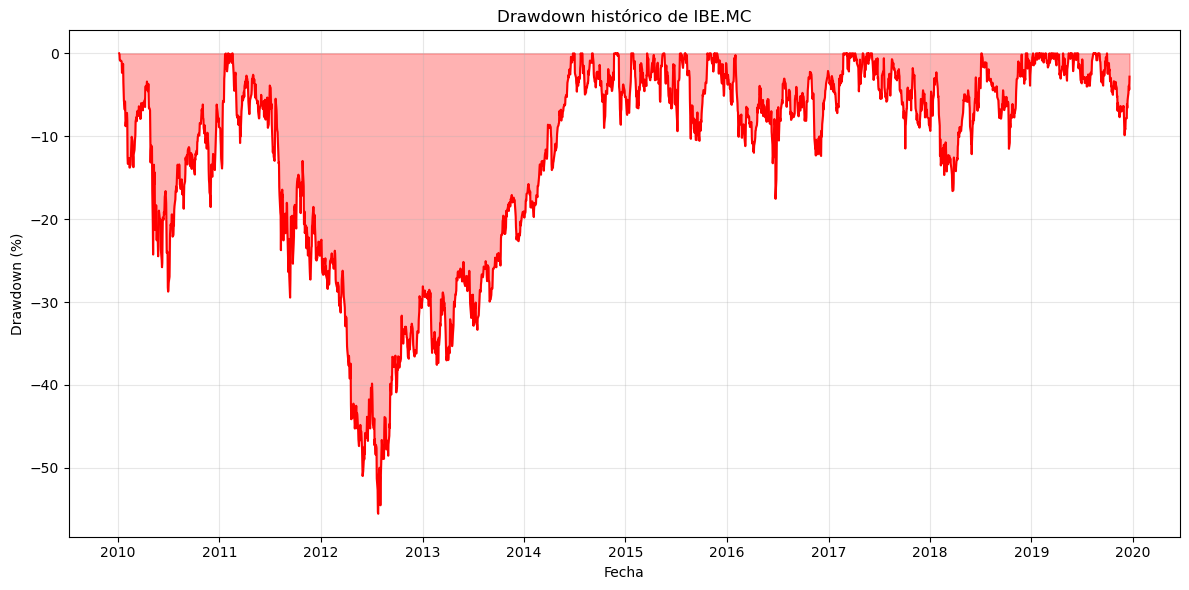

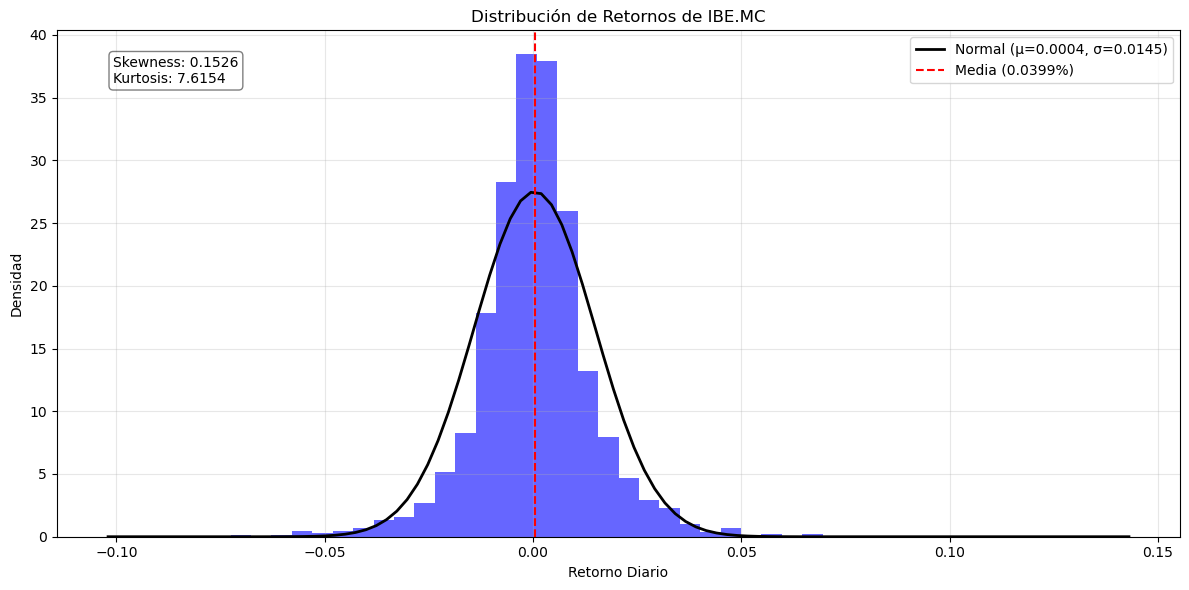

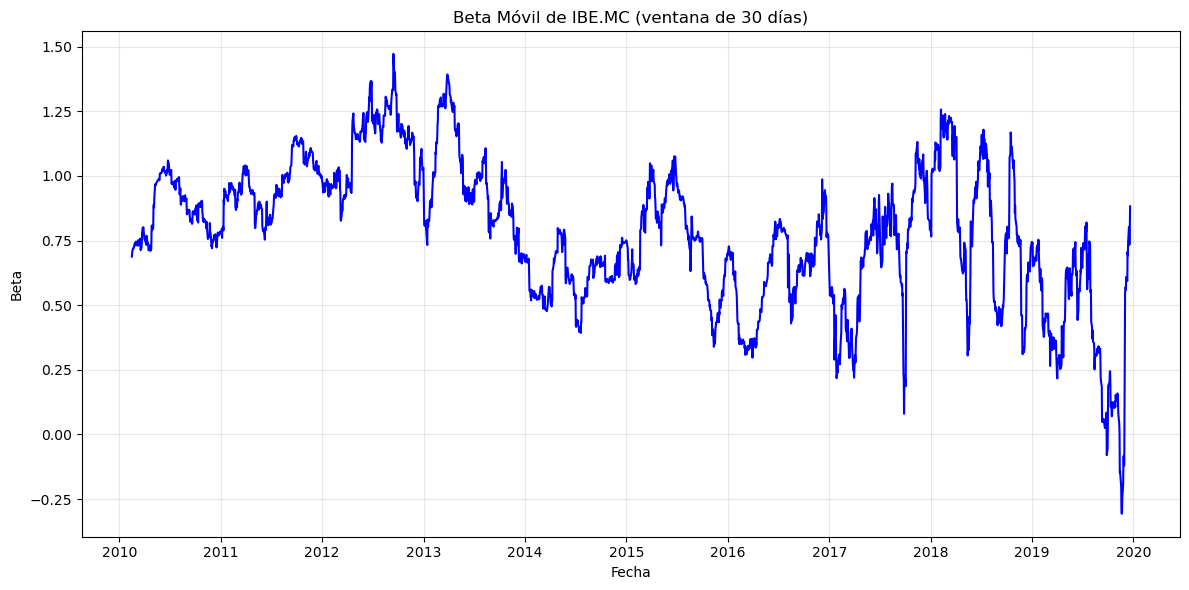

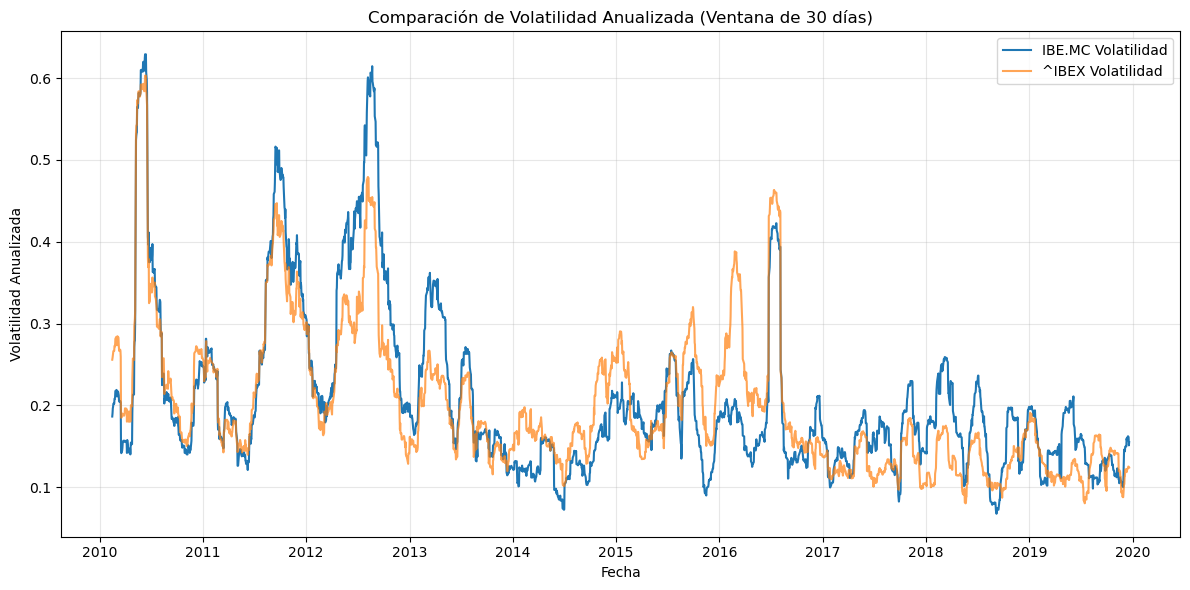

In [ ]:
import os
import pandas as pd
import yfinance as yf
from typing import Tuple, Optional
from pathlib import Path
import numpy as np
from scipy import stats
from queue import Queue

class RiskMetrics:
    def __init__(self, ticker, stock_returns, benchmark_returns, benchmark, risk_free_rate=0.0, returns_frequency='D'):
        """
        Inicializa la clase RiskMetrics.

        Args:
            ticker (str): Símbolo del activo.
            stock_returns (pd.Series): Serie de tiempo de retornos del activo.
            benchmark_returns (pd.Series): Serie de tiempo de retornos del benchmark.
            benchmark (str): Símbolo del benchmark.
            risk_free_rate (float): Tasa libre de riesgo anualizada.
            returns_frequency (str): Frecuencia de los retornos ('D', 'W', 'M', 'Y').
        """
        self.ticker = ticker
        self.stock_returns = stock_returns
        self.benchmark_returns = benchmark_returns
        self.benchmark = benchmark
        self.risk_free_rate = risk_free_rate
        self.value_returns_frequency = returns_frequency
        self.risk_metrics = {}
        self._set_annualization_factor()

    def _set_annualization_factor(self):
        """Establece el factor de anualización basado en la frecuencia de los retornos."""
        freq_map = {'D': 252, 'W': 52, 'M': 12, 'Y': 1}
        self.annualization_factor = freq_map.get(self.value_returns_frequency, 252)

    def calculate_risk_metrics(self):
        """Calcula métricas de riesgo (beta, sharpe, etc.)."""
        if self.stock_returns is not None and self.benchmark_returns is not None:
            # Alinear fechas para ambos retornos
            aligned_value_closures = pd.concat([self.stock_returns, self.benchmark_returns], axis=1).dropna()
            aligned_value_closures.columns = [self.ticker, self.benchmark]

            # Asignar para facilitar cálculos
            self.value_returns = aligned_value_closures[self.ticker]
            self.benchmark_returns = aligned_value_closures[self.benchmark]

            # Crear diccionario de métricas
            self.risk_metrics = {
                'beta': self.calculate_beta(),
                'alpha': self.calculate_alpha(),
                'sharpe_ratio': self.calculate_sharpe_ratio(),
                'information_ratio': self.calculate_information_ratio(),
                'treynor_ratio': self.calculate_treynor_ratio(),
                'correlation': self.calculate_correlation(),
                'skewness': self.calculate_skewness(),
                'kurtosis': self.calculate_kurtosis(),
                'max_drawdown': self.calculate_max_drawdown(),
                'sortino_ratio': self.calculate_sortino_ratio(),
                'winning_ratio': self.calculate_winning_ratio(),
                'volatility': self.calculate_volatility() * np.sqrt(self.annualization_factor)  # Anualizada
            }

            # Intentar calcular el periodo de recuperación (puede no aplicar)
            try:
                self.risk_metrics['recovery_period'] = self.calculate_recovery_period().days
            except:
                self.risk_metrics['recovery_period'] = None

    def calculate_volatility(self):
        """Calcula la volatilidad de los retornos."""
        return np.std(self.value_returns)

    def calculate_alpha(self):
        """Calcula el Alfa de Jensen."""
        if self.benchmark_returns is None:
            raise ValueError("Se necesitan retornos del mercado para calcular Alfa.")
        excess_returns = self.value_returns - self.risk_free_rate / self.annualization_factor
        excess_benchmark_returns = self.benchmark_returns - self.risk_free_rate / self.annualization_factor
        beta = self.calculate_beta()
        return np.mean(excess_returns - beta * excess_benchmark_returns)

    def calculate_beta(self):
        """Calcula el Beta (riesgo sistemático)."""
        if self.benchmark_returns is None:
            raise ValueError("Se necesitan retornos del mercado para calcular Beta.")
        return np.cov(self.value_returns, self.benchmark_returns)[0, 1] / np.var(self.benchmark_returns)

    def calculate_sharpe_ratio(self):
        """Calcula el ratio de Sharpe (exceso de retorno por unidad de riesgo)."""
        excess_returns = self.value_returns - self.risk_free_rate / self.annualization_factor
        volatility = self.calculate_volatility()
        return np.mean(excess_returns) / volatility

    def calculate_information_ratio(self):
        """Calcula el ratio de información (retorno activo por unidad de riesgo activo)."""
        if self.benchmark_returns is None:
            raise ValueError("Se necesitan retornos del mercado para calcular el Ratio de Información.")
        active_returns = self.value_returns - self.benchmark_returns
        tracking_error = np.std(active_returns)
        return np.mean(active_returns) / tracking_error

    def calculate_treynor_ratio(self):
        """Calcula el ratio de Treynor (exceso de retorno por unidad de riesgo sistemático)."""
        excess_returns = self.value_returns - self.risk_free_rate / self.annualization_factor
        beta = self.calculate_beta()
        if abs(beta) < 1e-8:  # Umbral para considerar beta como cero
            return np.nan  # O algún otro valor que indique indefinido
        return np.mean(excess_returns) / beta

    def calculate_correlation(self):
        """Calcula la correlación con el benchmark."""
        if self.benchmark_returns is None:
            raise ValueError("Se necesitan retornos del mercado para calcular la correlación.")
        return np.corrcoef(self.value_returns, self.benchmark_returns)[0, 1]

    def calculate_skewness(self):
        """Calcula la asimetría de los retornos (skewness)."""
        return stats.skew(self.value_returns)

    def calculate_kurtosis(self):
        """Calcula la curtosis de los retornos."""
        return stats.kurtosis(self.value_returns)

    def calculate_max_drawdown(self):
        """Calcula el máximo drawdown (caída máxima desde un pico)."""
        cumulative_returns = (1 + self.value_returns).cumprod()
        rolling_max = cumulative_returns.cummax()
        drawdown = cumulative_returns / rolling_max - 1
        return drawdown.min()

    def calculate_recovery_period(self):
        """Calcula el periodo de recuperación después del drawdown máximo."""
        cumulative_returns = (1 + self.value_returns).cumprod()
        peak_idx = cumulative_returns.idxmax()
        if peak_idx == cumulative_returns.index[-1]:
            return pd.Timedelta(0)  # No hubo drawdown, no hay recuperación
        post_peak_returns = cumulative_returns[cumulative_returns.index > peak_idx]
        trough_idx = post_peak_returns.idxmin()
        if trough_idx == cumulative_returns.index[-1]:
            return pd.Timedelta(np.nan)  # Aún no se ha recuperado
        post_trough_values = cumulative_returns[cumulative_returns.index > trough_idx]
        recovery_points = post_trough_values[post_trough_values >= cumulative_returns[peak_idx]]
        if recovery_points.empty:
            return pd.Timedelta(np.nan)  # No hubo recuperación completa
        recovery_idx = recovery_points.index[0]
        return recovery_idx - trough_idx

    def calculate_sortino_ratio(self):
        """Calcula el ratio de Sortino (considera solo la volatilidad negativa)."""
        excess_returns = self.value_returns - self.risk_free_rate / self.annualization_factor
        downside_returns = excess_returns[excess_returns < 0]
        if downside_returns.empty:
            return np.nan  # O un valor muy grande pero finito
        downside_deviation = np.std(downside_returns)
        if downside_deviation == 0:
            return np.nan  # O un valor muy grande pero finito
        return np.mean(excess_returns) / downside_deviation

    def calculate_winning_ratio(self):
        """Calcula el ratio de ganancia/pérdida."""
        positive_returns = self.value_returns[self.value_returns > 0]
        negative_returns = self.value_returns[self.value_returns < 0]
        if len(negative_returns) == 0:
            return np.nan  # O un valor muy grande pero finito
        return len(positive_returns) / len(negative_returns)

    def display_risk_metrics(self):
            """Muestra las métricas de riesgo calculadas."""
            if not hasattr(self, 'risk_metrics') or self.risk_metrics is None:
                print("No hay métricas de riesgo calculadas. Ejecute calculate_risk_metrics() primero.")
                return
            print(f"\n--- Métricas de Riesgo para {self.ticker} ---")
            formatted_metrics = {
                'Beta': f"{self.risk_metrics.get('beta', 'N/A'):.4f}",
                'Alpha (Jensen)': f"{self.risk_metrics.get('alpha', 'N/A'):.4%}",
                'Ratio de Sharpe': f"{self.risk_metrics.get('sharpe_ratio', 'N/A'):.4f}",
                'Ratio de Información': f"{self.risk_metrics.get('information_ratio', 'N/A'):.4f}",
                'Ratio de Treynor': f"{self.risk_metrics.get('treynor_ratio', 'N/A'):.4f}",
                'Correlación con el mercado': f"{self.risk_metrics.get('correlation', 'N/A'):.4f}",
                'Asimetría (Skewness)': f"{self.risk_metrics.get('skewness', 'N/A'):.4f}",
                'Curtosis (Kurtosis)': f"{self.risk_metrics.get('kurtosis', 'N/A'):.4f}",
                'Máximo Drawdown': f"{self.risk_metrics.get('max_drawdown', 'N/A'):.4%}",
                'Período de Recuperación': f"{self.risk_metrics.get('recovery_period', 'N/A')} días" if self.risk_metrics.get('recovery_period') else "N/A",
                'Ratio de Sortino': f"{self.risk_metrics.get('sortino_ratio', 'N/A'):.4f}" if self.risk_metrics.get('sortino_ratio') != float('inf') else "∞",
                'Ratio de Ganancia/Pérdida': f"{self.risk_metrics.get('winning_ratio', 'N/A'):.4f}" if self.risk_metrics.get('winning_ratio') != float('inf') else "∞",
                'Volatilidad Anualizada': f"{self.risk_metrics.get('volatility', 'N/A'):.4%}"
            }
            for metric, value in formatted_metrics.items():
                print(f"{metric}: {value}")

    def plot_risk_metrics(self):
        """Genera gráficos relacionados con las métricas de riesgo."""
        if not hasattr(self, 'risk_metrics') or self.risk_metrics is None:
            print("No hay métricas de riesgo calculadas. Ejecute calculate_risk_metrics() primero.")
            return
        self.plot_drawdown()
        self.plot_return_distribution()
        self.plot_rolling_beta(window=30)
        self.plot_volatility_comparison(window=30)

    def plot_drawdown(self):
        """Genera gráfico de drawdown."""
        cumulative_returns = (1 + self.value_returns).cumprod()
        rolling_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns / rolling_max - 1) * 100  # En porcentaje
        plt.figure(figsize=(12, 6))
        plt.plot(drawdown, color='red', linewidth=1.5)
        plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
        plt.title(f'Drawdown histórico de {self.ticker}')
        plt.ylabel('Drawdown (%)')
        plt.xlabel('Fecha')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_return_distribution(self):
        """Genera histograma de distribución de retornos con comparación con distribución normal."""
        plt.figure(figsize=(12, 6))
        n, bins, patches = plt.hist(self.value_returns, bins=50, density=True, alpha=0.6, color='blue')
        mu, sigma = stats.norm.fit(self.value_returns)
        x = np.linspace(self.value_returns.min(), self.value_returns.max(), 100)
        p = stats.norm.pdf(x, mu, sigma)
        plt.plot(x, p, 'k', linewidth=2, label=f'Normal (μ={mu:.4f}, σ={sigma:.4f})')
        plt.axvline(x=np.mean(self.value_returns), color='red', linestyle='--', label=f'Media ({np.mean(self.value_returns):.4%})')
        textstr = f'Skewness: {self.risk_metrics.get("skewness", "N/A"):.4f}\n'
        textstr += f'Kurtosis: {self.risk_metrics.get("kurtosis", "N/A"):.4f}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=props)
        plt.title(f'Distribución de Retornos de {self.ticker}')
        plt.xlabel('Retorno Diario')
        plt.ylabel('Densidad')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_rolling_beta(self, window=30):
        """
        Genera un gráfico de Beta móvil.

        Args:
            window (int): Tamaño de la ventana móvil para calcular el Beta. Default es 30.
        """
        if self.value_returns is None or self.benchmark_returns is None:
            print("Error: Primero carga los datos de retornos y benchmark.")
            return

        # Crear un DataFrame con los retornos del activo y del benchmark
        df = pd.DataFrame({
            'returns': self.value_returns,
            'benchmark': self.benchmark_returns
        }).dropna()

        if df.empty:
            print("Error: Series temporales no alineadas o insuficientes datos.")
            return

        rolling_betas = []
        for i in range(len(df) - window + 1):
            if i + window <= len(df):
                window_df = df.iloc[i:i+window]
                returns_window = window_df['returns']
                benchmark_window = window_df['benchmark']

                # Calcular la covarianza y la varianza
                cov = np.cov(returns_window, benchmark_window, ddof=1)[0, 1]
                var = np.var(benchmark_window, ddof=1)

                # Calcular el Beta
                if var != 0:
                    beta = cov / var
                else:
                    beta = np.nan

                rolling_betas.append(beta)
            else:
                break

        # Crear una serie temporal con los betas calculados
        rolling_beta_series = pd.Series(rolling_betas, index=df.index[window-1:window-1+len(rolling_betas)])

        if rolling_beta_series.empty:
            print("Error: No se pudo calcular ningún valor de beta.")
            return

        # Graficar el Beta móvil
        plt.figure(figsize=(12, 6))
        plt.plot(rolling_beta_series, color='blue', linewidth=1.5)
        plt.title(f'Beta Móvil de {self.ticker} (ventana de {window} días)')
        plt.ylabel('Beta')
        plt.xlabel('Fecha')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_volatility_comparison(self, window=30):
            """Genera gráfico comparando volatilidad del activo y el benchmark."""
            # Calcular volatilidad móvil
            stock_vol = self.value_returns.rolling(window=window).std() * np.sqrt(self.annualization_factor)  # Anualizada
            benchmark_vol = self.benchmark_returns.rolling(window=window).std() * np.sqrt(self.annualization_factor)  # Anualizada

            # Crear gráfico
            plt.figure(figsize=(12, 6))
            plt.plot(stock_vol, label=f'{self.ticker} Volatilidad', linewidth=1.5)
            plt.plot(benchmark_vol, label=f'{self.benchmark} Volatilidad', linewidth=1.5, alpha=0.7)

            plt.title(f'Comparación de Volatilidad Anualizada (Ventana de {window} días)')
            plt.ylabel('Volatilidad Anualizada')
            plt.xlabel('Fecha')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    def get_risk_summary(self):
        """Devuelve un resumen de las métricas de riesgo más importantes."""
        if not hasattr(self, 'risk_metrics') or self.risk_metrics is None:
            return "No hay métricas de riesgo calculadas."

        # Clasificar beta
        beta = self.risk_metrics.get('beta', 0)
        if beta < 0.8:
            beta_comment = "defensivo (menos volátil que el mercado)"
        elif beta < 1.2:
            beta_comment = "neutral (similar al mercado)"
        else:
            beta_comment = "agresivo (más volátil que el mercado)"

        # Clasificar alpha
        alpha = self.risk_metrics.get('alpha', 0)
        if alpha > 0.01:  # 1% anual
            alpha_comment = "positivo significativo"
        elif alpha > 0:
            alpha_comment = "ligeramente positivo"
        elif alpha > -0.01:
            alpha_comment = "ligeramente negativo"
        else:
            alpha_comment = "negativo significativo"

        # Clasificar Sharpe
        sharpe = self.risk_metrics.get('sharpe_ratio', 0)
        if sharpe > 1:
            sharpe_comment = "bueno"
        elif sharpe > 0.5:
            sharpe_comment = "aceptable"
        elif sharpe > 0:
            sharpe_comment = "bajo"
        else:
            sharpe_comment = "negativo"

        # Crear resumen
        summary = f"Resumen de riesgo para {self.ticker}:\n\n"
        summary += f"- Beta: {beta:.2f} ({beta_comment})\n"
        summary += f"- Alpha: {alpha:.2%} ({alpha_comment})\n"
        summary += f"- Ratio de Sharpe: {sharpe:.2f} ({sharpe_comment})\n"
        summary += f"- Máximo Drawdown: {self.risk_metrics.get('max_drawdown', 0):.2%}\n"
        summary += f"- Volatilidad anualizada: {self.risk_metrics.get('volatility', 0):.2%}\n"

        return summary

if __name__ == "__main__":
    # Obtener los datos de la clase Importarquotes
    benchmark_value_closures =quotes.benchmark_value_closures
    benchmark_returns =quotes.benchmark_returns
    value_closures =quotes.value_closures
    value_returns =quotes.value_returns
    ticker =quotes.ticker
    benchmark =quotes.benchmark  # Asegúrate de que este atributo esté definido en Importarquotes

    # Definir la tasa libre de riesgo y la frecuencia de los retornos
    risk_free_rate = 0.02  # 2% anual
    returns_frequency = 'D'  # Retornos diarios

    # Crear una instancia de RiskMetrics con los datos obtenidos
    risk_metrics = RiskMetrics(
        ticker=ticker,
        stock_returns=value_returns,
        benchmark_returns=benchmark_returns,
        benchmark=benchmark,
        risk_free_rate=risk_free_rate,
        returns_frequency=returns_frequency
    )

    # Calcular métricas de riesgo
    risk_metrics.calculate_risk_metrics()

    # Mostrar métricas de riesgo
    risk_metrics.display_risk_metrics()

    # Obtener y mostrar el resumen de riesgo
    risk_summary = risk_metrics.get_risk_summary()  # Llamada al método get_risk_summary
    print("\n--- Resumen de Riesgo ---")
    print(risk_summary)

    # Graficar métricas de riesgo
    risk_metrics.plot_risk_metrics()




## ANALISIS DE RESULTADOS (Perplexity):

El análisis de las métricas de riesgo de Iberdrola (IBE.MC) frente al IBEX 35 entre 2010-2019 revela un perfil de riesgo con características destacables:

---

### **Riesgo sistemático y correlación de mercado**  
- **Beta de 0.88** indica que la acción es ligeramente menos volátil que el mercado (IBEX 35)[1][3].  
- **Correlación de 83.38%** confirma una alta sincronización con los movimientos del índice de referencia, aunque con menor amplitud[1].  
- **Alpha del 0.04%** sugiere una sobreperformance mínima respecto al rendimiento esperado por el CAPM, coincidiendo con el estudio que vincula su rentabilidad al contexto del IBEX 35[1].

---

### **Rendimiento ajustado al riesgo**  
- **Ratio de Sharpe (0.023)** y **Treynor (0.0004)** extremadamente bajos: reflejan una compensación insuficiente por el riesgo asumido, especialmente relevante dado el **máximo drawdown del -55.53%** (relacionado con la crisis de 2008-2015 donde cotizó <6€/acción)[1][3].  
- **Volatilidad anualizada del 23%** y **Curtosis de 7.65**: indican alta probabilidad de eventos extremos, compatible con la crisis energética y ajustes de deuda descritos en los informes[1][3].

---

### **Perfil asimétrico y capacidad de recuperación**  
- **Skewness positivo (0.15)** muestra sesgo hacia rendimientos ligeramente superiores, aunque limitado por:  
  - **Ratio Ganancia/Pérdida de 1.07**: equilibrio frágil entre éxitos y pérdidas.  
  - **Recuperación de drawdown no alcanzada** en el periodo analizado, vinculado a la transformación de deuda a corto plazo mencionada en los estados financieros[1][3].

---

### **Contexto estratégico**  
- La **alta exposición a riesgos geopolíticos** (guerra en Ucrania, tensiones en Oriente Medio)[3] y **dependencia de precios regulados** explican parte de la volatilidad.  
- La **elevada inversión en renovables** (81% de capacidad libre de emisiones en 2021)[2] introduce incertidumbre a largo plazo pese a su alineación con tendencias globales.  
- El **ROE <10%** y **PER elevado (14.9 vs 11.8 de Endesa)**[3] limitan el atractivo frente a competidores, aunque se compensa parcialmente con su posición como cuarta eléctrica mundial[3].

---

### **Conclusión**  
Iberdrola muestra un perfil **defensivo moderado** con riesgo idiosincrático elevado por su estructura financiera (fondo de maniobra negativo, deuda a corto plazo creciente)[1][3]. Su rendimiento está íntimamente ligado al IBEX 35, pero con capacidad limitada para generar alpha en condiciones de estrés de mercado. La combinación de alta curtosis, drawdown histórico severo y ratios de ajuste al riesgo modestos la posicionan como una inversión **apta para horizontes largos**, donde su apuesta por transición energética podría materializar ventajas competitivas[2][3].

Citations:
[1] https://biblioteca.cunef.edu/files/documentos/TFG_Beatriz_Castro-Rial_Resines.pdf

[2] https://www.iberdrola.com/documents/20125/1606413/jga22_IA_InformeIntegrado22.pdf

[3] https://www.precioobjetivo.com/iberdrola/

[4] https://www.cnmv.es/portal/consultas/ifa/listadoifa.aspx?id=0&nif=A-48010615&lang=es

[5] https://www.cnmv.es/webservices/verdocumento/ver?e=Yo9pqRCZsumDUGkyKL32cq0OKXptR67JwyRLUorugNj1xVx9TYwe6nqlQTLZolJy

[6] https://repositorio.comillas.edu/xmlui/handle/11531/45

[7] https://www.iberdrolaenergiaespana.es/documents/2010275/2426178/Sistema_Gobernanza_Sostenibilidad.pdf

[8] https://portal.findresearcher.sdu.dk/files/215797653/Informe_Cotec_Economia_Circular_2021_vfinal.pdf

[9] https://www.iberdrola.com/documents/20125/41908/gobierno_corporativo.pdf

---
Respuesta de Perplexity: pplx.ai/share



# Gráficas de MACD, ATR, BB, ADX y RSI

## Plot matplotlib candlestick

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.dates import DateFormatter

class Candlestick:
    def __init__(self, quotes):
        """
        Initialize Candlestick class with data.
        Args:
            quotes: Objeto que contiene un dataframe con los datos OHLC.
        """
        if not hasattr(quotes, 'value_closures') or not isinstance(quotes.value_closures, pd.DataFrame):
            raise ValueError("quotes.value_closures debe ser un DataFrame de pandas.")

        if quotes.value_closures.empty:
            raise ValueError("DataFrame 'quotes.value_closures' is empty.")

        self.df = quotes.value_closures.copy()
        if hasattr(quotes, 'ticker'):
            self.ticker = quotes.ticker
        else:
            self.ticker = "Ticker no disponible"

    def plot_candlestick(self):
        # Convertir las fechas de nuevo a objetos de fecha
        self.df['date'] = pd.to_datetime(self.df.index)

        # Convierte las fechas a números enteros para usarlas en candlestick_ohlc
        ohlc = self.df[['date', 'Open', 'High', 'Low', 'Close']].copy()
        ohlc['date'] = ohlc['date'].apply(mdates.date2num)
        ohlc = ohlc.values

        # Crea una figura y un eje
        self.fig, self.ax = plt.subplots(figsize=(12, 8))

        # Grafica los candlesticks
        candlestick_ohlc(self.ax, ohlc, width=0.7, colorup='green', colordown='red', alpha=0.8)

        # Personaliza el eje x para mostrar las fechas
        date_format = DateFormatter('%Y-%m-%d')
        self.ax.xaxis.set_major_formatter(date_format)
        plt.xticks(rotation=45)

        # Agrega títulos y etiquetas de los ejes
        plt.title(f"Historical Stock Price for {self.ticker}", fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

        # Muestra el gráfico
        plt.show()

# Ejemplo de uso (asumiendo que 'quotes' es un objeto con 'value_closures' y 'ticker')
# quotes = Importarquotes() # instancia de tu clase Importarquotes.
candlestick_obj = Candlestick(quotes)
candlestick_obj.plot_candlestick()


## Plot plotly candlestick

In [ ]:
import pandas as pd
import plotly.graph_objects as go

class Candlestick:
    def __init__(self, quotes):
        """
        Initialize Candlestick class with data.
        Args:
            quotes: Instance of Importarquotes containing OHLC data.
        """
        self.quotes = quotes
        self.df = quotes.value_closures.copy() # Cambio aqui
        self.ticker = quotes.ticker # Cambio aqui

    def plot_candlestick(self):
        fig = go.Figure(data=[go.Candlestick(x=self.df.index,
                                             open=self.df['Open'],
                                             high=self.df['High'],
                                             low=self.df['Low'],
                                             close=self.df['Close'])])

        fig.update_layout(
            title=f"Historical Stock Price for {self.ticker}",
            xaxis_title="Date",
            yaxis_title="Price",
            xaxis_rangeslider_visible=False,
            showlegend=False
        )

        fig.show()

# Ejemplo de uso
# quotes = Importarquotes()
# quotes.solicitar_datos()
candlestick_obj = Candlestick(quotes)
candlestick_obj.plot_candlestick()

## Gráfica matplotlib de Bollinger Bands.

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

class BollingerBands:
    def __init__(self, data, window, n_std):
        """
        Initialize Bollinger Bands class with data, window size, and standard deviation multiplier.

        Args:
            data: Instance of Importarquotes containing OHLC data.
            window: Window size for moving average.
            n_std: Number of standard deviations for the bands.
        """
        if hasattr(data, 'value_closures'):  # Si es un objeto 'Importarquotes'
            self.df = data.value_closures.copy()
        elif isinstance(data, pd.DataFrame):  # Si es un DataFrame
            self.df = data.copy()
        else:
            raise ValueError("Input must be an instance of 'Importarquotes' or a pandas DataFrame")

        if 'Close' not in self.df.columns:
            self.df = self.df.rename(columns={self.df.columns[0]: 'Close'})

        self.window = window
        self.n_std = n_std
        self._calculate_bands()

    def _calculate_bands(self):
        """
        Calculate the Bollinger Bands.
        """
        self.sma = self.df["Close"].rolling(window=self.window).mean()
        self.std = self.df["Close"].rolling(window=self.window).std()
        self.upper_band = self.sma + self.n_std * self.std
        self.lower_band = self.sma - self.n_std * self.std

    def plot(self):
        """
        Plot the Bollinger Bands along with the close prices.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.df.index, self.df["Close"], label="Precio de cierre", lw=1.5)
        plt.plot(self.df.index, self.sma, label=f"Media móvil simple de {self.window} días", lw=1.5)
        plt.plot(self.df.index, self.upper_band, label=f"Banda superior de Bollinger ({self.n_std} std)", lw=1.5)
        plt.plot(self.df.index, self.lower_band, label=f"Banda inferior de Bollinger ({self.n_std} std)", lw=1.5)
        plt.fill_between(self.df.index, self.upper_band.values, self.lower_band.values, color='blue', alpha=0.1)
        plt.legend(fontsize=8)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.xlabel("Fecha", fontsize=10)
        plt.ylabel("Precio", fontsize=10)
        plt.title("Bollinger Bands", fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Ejemplo de uso (asumiendo que 'quotes' es una instancia de Importarquotes)
bb = BollingerBands(quotes, window=20, n_std=2)
bb.plot()

## Gráfica plotly de Bollinger Bands

In [ ]:
import plotly.graph_objects as go

class BollingerBands:
    def __init__(self, quotes, window=20, n_std=2):
        """
        Initialize Bollinger Bands class with data from Importarquotes, window size, and standard deviation multiplier.

        Args:
            quotes: Instance of Importarquotes containing OHLC data.
            window: Window size for moving average.
            n_std: Number of standard deviations for the bands.
        """
        self.quotes = quotes
        self.df = quotes.value_closures  # Use the filtered value_closures DataFrame
        self.window = window
        self.n_std = n_std
        self._calculate_bands()

    def _calculate_bands(self):
        self.sma = self.df["Close"].rolling(window=self.window).mean()
        self.std = self.df["Close"].rolling(window=self.window).std()
        self.upper_band = self.sma + self.n_std * self.std
        self.lower_band = self.sma - self.n_std * self.std

    def plot(self):
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=self.df.index, y=self.df["Close"], name="Precio de cierre", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.df.index, y=self.sma, name=f"Media móvil simple de {self.window} días", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.df.index, y=self.upper_band, name=f"Banda superior de Bollinger ({self.n_std} std)", line=dict(width=1.5)))
        fig.add_trace(go.Scatter(x=self.df.index, y=self.lower_band, name=f"Banda inferior de Bollinger ({self.n_std} std)", line=dict(width=1.5)))
        fig.update_layout(
            title="Bollinger Bands",
            xaxis_title="Fecha",
            yaxis_title="Precio",
            xaxis_rangeslider_visible=False,
            showlegend=True,
            legend=dict(x=0, y=1)
        )

        fig.show()

# Ejemplo de uso (asumiendo que 'quotes' es una instancia de Importarquotes)
bb = BollingerBands(quotes, window=20, n_std=2)
bb.plot()


## Gráfica matplotlib del ATR.

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional, Dict, Any

class ATR:
    """
    Average True Range (ATR) quotes class with visualization capabilities.
    """

    def __init__(self, quotes) -> None:
        """
        Initialize ATR quotes with price data.

        Args:
            quotes: Price data source containing OHLC data
        """
        self.quotes = quotes

        # Esperamos a que los datos estén cargados
        if not hasattr(quotes, 'value_closures') or quotes.value_closures.empty:
            raise ValueError("Por favor, asegúrate de cargar los datos antes de crear el objeto ATR")

        # Usamos el DataFrame completo de quotes
        self.df = quotes.value_closures.copy()

        # Aseguramos que tenemos las columnas necesarias
        if not all(col in self.df.columns for col in ['High', 'Low', 'Close']):
            # Intentamos usar las columnas alternativas si están disponibles
            if 'high' in self.df.columns:
                self.df['High'] = self.df['high']
            if 'low' in self.df.columns:
                self.df['Low'] = self.df['low']
            if 'close' in self.df.columns:
                self.df['Close'] = self.df['close']

        self.ticker = getattr(quotes, 'ticker', 'Unknown')
        self._validate_data()
        self.upper_limit: float = 0
        self.lower_limit: float = 0

    def _validate_data(self) -> None:
        """Validate that DataFrame contains required columns."""
        required_columns = {'Close', 'High', 'Low'}
        missing_columns = required_columns - set(self.df.columns)
        if missing_columns:
            raise ValueError(
                f"Faltan columnas requeridas: {missing_columns}. "
                f"El DataFrame debe contener: {required_columns}"
            )

    def calculate_sma(self, windows: Tuple[int, ...] = (20, 50)) -> None:
        """
        Calculate multiple Simple Moving Averages.

        Args:
            windows: Tuple de períodos para el cálculo de SMA
        """
        for window in windows:
            column_name = f'SMA{window}'
            self.df[column_name] = self.df['Close'].rolling(
                window=window,
                min_periods=1
            ).mean()

    def calculate_atr(self, window: int = 14) -> None:
        """
        Calculate ATR and True Range for the specified period.

        Args:
            window: Período para el cálculo de ATR (default: 14)
        """
        high_low = self.df['High'] - self.df['Low']
        high_close = abs(self.df['High'] - self.df['Close'].shift())
        low_close = abs(self.df['Low'] - self.df['Close'].shift())

        tr = pd.DataFrame({
            'hl': high_low,
            'hc': high_close,
            'lc': low_close
        }).max(axis=1)

        self.df['TR'] = tr
        self.df['ATR'] = tr.rolling(window=window, min_periods=1).mean()
        self._calculate_volatility_bands()

    def _calculate_volatility_bands(self, std_dev: float = 2.0) -> None:
        """
        Calculate volatility bands based on ATR statistics.

        Args:
            std_dev: Número de desviaciones estándar para las bandas (default: 2.0)
        """
        self.upper_limit = self.df['ATR'].mean() + std_dev * self.df['ATR'].std()
        self.lower_limit = self.df['ATR'].mean() - std_dev * self.df['ATR'].std()

    def plot_atr(self, sma_windows: Optional[Tuple[int, ...]] = None) -> None:
        """
        Generate enhanced visualization of price, ATR, and indicators.

        Args:
            sma_windows: Tupla opcional de períodos SMA para graficar
        """
        fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

        # Price chart
        axs[0].plot(self.df.index, self.df['Close'],
                   label='Precio', color='blue', linewidth=1.5)

        # Add SMAs if specified
        if sma_windows:
            colors = plt.cm.viridis(np.linspace(0, 1, len(sma_windows)))
            for window, color in zip(sma_windows, colors):
                column_name = f'SMA{window}'
                if column_name in self.df.columns:
                    axs[0].plot(self.df.index, self.df[column_name],
                               label=f'SMA {window}', color=color,
                               linewidth=1.5, alpha=0.7)

        # ATR chart
        axs[1].plot(self.df.index, self.df['ATR'],
                   label='ATR', color='purple', linewidth=1.5)
        axs[1].plot(self.df.index, self.df['TR'],
                   label='TR', color='gray', alpha=0.3)
        axs[1].axhline(y=self.upper_limit, linestyle='--',
                      color='red', label='Límite Superior')
        axs[1].axhline(y=self.lower_limit, linestyle='--',
                      color='green', label='Límite Inferior')

        # Style enhancement
        for ax in axs:
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.legend(loc='upper left', framealpha=0.9)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # Labels and title
        fig.suptitle(f'Análisis ATR - {self.ticker}',
                    fontsize=16, y=1.02)
        axs[0].set_title('Gráfico de Precios', pad=10)
        axs[1].set_title('Indicadores ATR/TR', pad=10)
        axs[0].set_ylabel('Precio')
        axs[1].set_ylabel('Valor ATR/TR')
        axs[1].set_xlabel('Fecha')

        # Format x-axis
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def get_signals(self, threshold: float = 0.5) -> pd.Series:
        """
        Generate trading signals based on ATR thresholds.

        Args:
            threshold: Umbral para generación de señales (default: 0.5)

        Returns:
            Series con señales de trading (1: compra, -1: venta, 0: mantener)
        """
        signals = pd.Series(0, index=self.df.index)
        signals[self.df['ATR'] > self.upper_limit] = 1
        signals[self.df['ATR'] < self.lower_limit] = -1
        return signals

    def get_statistics(self) -> Dict[str, float]:
        """
        Calculate and return key ATR statistics.

        Returns:
            Diccionario conteniendo estadísticas ATR
        """
        return {
            'mean_atr': self.df['ATR'].mean(),
            'std_atr': self.df['ATR'].std(),
            'max_atr': self.df['ATR'].max(),
            'min_atr': self.df['ATR'].min(),
            'current_atr': self.df['ATR'].iloc[-1],
            'upper_band': self.upper_limit,
            'lower_band': self.lower_limit
        }

# Ejemplo de uso
# Crear objeto de quotes
#quotes = Importarquotes()

# Solicitar datos al usuario y obtener DataFrames
#quotes.solicitar_datos()
atr = ATR(quotes)  # Crear el objeto ATR

# Calcular SMAs y ATR
atr.calculate_sma()
atr.calculate_atr()

# Graficar ATR y SMAs
atr.plot_atr(sma_windows=(20, 50))

## Gráfica plotly del ATR.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional, Dict, Any

class ATR:
    """
    Average True Range (ATR) quotes class with visualization capabilities.
    """

    def __init__(self, quotes) -> None:
        """
        Initialize ATR quotes with price data.

        Args:
            quotes: Price data source containing OHLC data
        """
        self.quotes = quotes

        # Esperamos a que los datos estén cargados
        if not hasattr(quotes, 'value_closures') or quotes.value_closures.empty:
            raise ValueError("Por favor, asegúrate de cargar los datos antes de crear el objeto ATR")

        # Usamos el DataFrame completo de quotes
        self.df = quotes.value_closures.copy()

        # Aseguramos que tenemos las columnas necesarias
        if not all(col in self.df.columns for col in ['High', 'Low', 'Close']):
            # Intentamos usar las columnas alternativas si están disponibles
            if 'high' in self.df.columns:
                self.df['High'] = self.df['high']
            if 'low' in self.df.columns:
                self.df['Low'] = self.df['low']
            if 'close' in self.df.columns:
                self.df['Close'] = self.df['close']

        self._validate_data()
        self.upper_limit: float = 0
        self.lower_limit: float = 0

    def _validate_data(self) -> None:
        """Validate that DataFrame contains required columns."""
        required_columns = {'Close', 'High', 'Low'}
        missing_columns = required_columns - set(self.df.columns)
        if missing_columns:
            raise ValueError(
                f"Faltan columnas requeridas: {missing_columns}. "
                f"El DataFrame debe contener: {required_columns}"
            )

    def calculate_sma(self, windows: Tuple[int, ...] = (20, 50)) -> None:
        """
        Calculate multiple Simple Moving Averages.

        Args:
            windows: Tuple de períodos para el cálculo de SMA
        """
        for window in windows:
            column_name = f'SMA{window}'
            self.df[column_name] = self.df['Close'].rolling(
                window=window,
                min_periods=1
            ).mean()

    def calculate_atr(self, window: int = 14) -> None:
        """
        Calculate ATR and True Range for the specified period.

        Args:
            window: Período para el cálculo de ATR (default: 14)
        """
        high_low = self.df['High'] - self.df['Low']
        high_close = abs(self.df['High'] - self.df['Close'].shift())
        low_close = abs(self.df['Low'] - self.df['Close'].shift())

        tr = pd.DataFrame({
            'hl': high_low,
            'hc': high_close,
            'lc': low_close
        }).max(axis=1)

        self.df['TR'] = tr
        self.df['ATR'] = tr.rolling(window=window, min_periods=1).mean()
        self._calculate_volatility_bands()

    def _calculate_volatility_bands(self, std_dev: float = 2.0) -> None:
        """
        Calculate volatility bands based on ATR statistics.

        Args:
            std_dev: Número de desviaciones estándar para las bandas (default: 2.0)
        """
        self.upper_limit = self.df['ATR'].mean() + std_dev * self.df['ATR'].std()
        self.lower_limit = self.df['ATR'].mean() - std_dev * self.df['ATR'].std()

    def plot_atr(self, sma_windows: Optional[Tuple[int, ...]] = None) -> None:
        """
        Generate enhanced visualization of price, ATR, and indicators.

        Args:
            sma_windows: Tupla opcional de períodos SMA para graficar
        """
        fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True,
                                gridspec_kw={'height_ratios': [2, 1]})

        # Price chart
        axs[0].plot(self.df.index, self.df['Close'],
                    label='Precio', color='blue', linewidth=1.5)

        # Add SMAs if specified
        if sma_windows:
            colors = plt.cm.viridis(np.linspace(0, 1, len(sma_windows)))
            for window, color in zip(sma_windows, colors):
                column_name = f'SMA{window}'
                if column_name in self.df.columns:
                    axs[0].plot(self.df.index, self.df[column_name],
                                label=f'SMA {window}', color=color,
                                linewidth=1.5, alpha=0.7)

        # ATR chart
        axs[1].plot(self.df.index, self.df['ATR'],
                    label='ATR', color='purple', linewidth=1.5)
        axs[1].plot(self.df.index, self.df['TR'],
                    label='TR', color='gray', alpha=0.3)
        axs[1].axhline(y=self.upper_limit, linestyle='--',
                    color='red', label='Límite Superior')
        axs[1].axhline(y=self.lower_limit, linestyle='--',
                    color='green', label='Límite Inferior')

        # Style enhancement
        for ax in axs:
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.legend(loc='upper left', framealpha=0.9)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # Labels and title
        fig.suptitle(f'Análisis ATR - {self.quotes.ticker}',
                    fontsize=16, y=1.02)
        axs[0].set_title('Gráfico de Precios', pad=10)
        axs[1].set_title('Indicadores ATR/TR', pad=10)
        axs[0].set_ylabel('Precio')
        axs[1].set_ylabel('Valor ATR/TR')
        axs[1].set_xlabel('Fecha')

        # Format x-axis
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def get_signals(self, threshold: float = 0.5) -> pd.Series:
        """
        Generate trading signals based on ATR thresholds.

        Args:
            threshold: Umbral para generación de señales (default: 0.5)

        Returns:
            Series con señales de trading (1: compra, -1: venta, 0: mantener)
        """
        signals = pd.Series(0, index=self.df.index)
        signals[self.df['ATR'] > self.upper_limit] = 1
        signals[self.df['ATR'] < self.lower_limit] = -1
        return signals

def get_statistics(self) -> Dict[str, float]:
        """
        Calculate and return key ATR statistics.

        Returns:
            Diccionario conteniendo estadísticas ATR
        """
        return {
            'mean_atr': self.df['ATR'].mean(),
            'std_atr': self.df['ATR'].std(),
            'max_atr': self.df['ATR'].max(),
            'min_atr': self.df['ATR'].min(),
            'current_atr': self.df['ATR'].iloc[-1],
            'upper_band': self.upper_limit,
            'lower_band': self.lower_limit  # Corregido: solo una clave 'lower_band'
        }
# Ejemplo de uso
# Crear objeto de quotes
# quotes = Importarquotes()

# Solicitar datos al usuario y obtener DataFrames
# quotes.solicitar_datos()
atr = ATR(quotes)  # Crear el objeto ATR

# Calcular SMAs y ATR
atr.calculate_sma()
atr.calculate_atr()

# Graficar ATR y SMAs
atr.plot_atr(sma_windows=(20, 50))







## Gráfica matplotlib del ADX.

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Optional, Tuple, Dict

class ADX:
    """
    Average Directional Index (ADX) quotes class with custom implementation.
    """

    def __init__(self, quotes) -> None:
        """
        Initialize ADX quotes with price data.

        Args:
            quotes: Price data source containing OHLC data
        """
        self.quotes = quotes

        # Esperamos a que los datos estén cargados
        if not hasattr(quotes, 'value_closures') or quotes.value_closures.empty:
            raise ValueError("Por favor, asegúrate de cargar los datos antes de crear el objeto ADX")

        # Usamos el DataFrame completo de quotes
        self.df = quotes.value_closures.copy()

        # Aseguramos que tenemos las columnas necesarias
        if not all(col in self.df.columns for col in ['High', 'Low', 'Close']):
            # Intentamos usar las columnas alternativas si están disponibles
            if 'high' in self.df.columns:
                self.df['High'] = self.df['high']
            if 'low' in self.df.columns:
                self.df['Low'] = self.df['low']
            if 'close' in self.df.columns:
                self.df['Close'] = self.df['close']

        self._validate_data()
        self.upper_limit: float = 0
        self.lower_limit: float = 0

        # Initialize indicators
        self.adx: Optional[pd.Series] = None
        self.plus_di: Optional[pd.Series] = None
        self.minus_di: Optional[pd.Series] = None

    def _validate_data(self) -> None:
        """Validate that DataFrame contains required columns."""
        required_columns = {'Close', 'High', 'Low'}
        missing_columns = required_columns - set(self.df.columns)
        if missing_columns:
            raise ValueError(
                f"Missing required columns: {missing_columns}. "
                f"DataFrame must contain: {required_columns}"
            )

    def _true_range(self) -> pd.Series:
        """Calculate True Range."""
        high = self.df['High']
        low = self.df['Low']
        close = self.df['Close']

        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())

        tr = pd.DataFrame({
            'tr1': tr1,
            'tr2': tr2,
            'tr3': tr3
        }).max(axis=1)

        return tr

    def _directional_movement(self) -> Tuple[pd.Series, pd.Series]:
        """Calculate +DM and -DM."""
        high = self.df['High']
        low = self.df['Low']

        up_move = high - high.shift()
        down_move = low.shift() - low

        plus_dm = pd.Series(0.0, index=up_move.index)
        minus_dm = pd.Series(0.0, index=down_move.index)

        plus_dm[up_move > down_move] = np.maximum(up_move, 0)[up_move > down_move]
        minus_dm[down_move > up_move] = np.maximum(down_move, 0)[down_move > up_move]

        plus_dm[up_move <= 0] = 0
        minus_dm[down_move <= 0] = 0

        return plus_dm, minus_dm

    def calculate_adx(self, period: int = 14) -> None:
        """
        Calculate ADX and directional indicators.

        Args:
            period: Length of lookback period for calculations
        """
        # Calculate True Range and Directional Movement
        tr = self._true_range()
        plus_dm, minus_dm = self._directional_movement()

        # Calculate smoothed values
        smoothed_tr = tr.rolling(window=period).sum()
        smoothed_plus_dm = plus_dm.rolling(window=period).sum()
        smoothed_minus_dm = minus_dm.rolling(window=period).sum()

        # Calculate +DI and -DI
        self.plus_di = 100 * smoothed_plus_dm / smoothed_tr
        self.minus_di = 100 * smoothed_minus_dm / smoothed_tr

        # Calculate DX
        dx = 100 * abs(self.plus_di - self.minus_di) / (self.plus_di + self.minus_di)

        # Calculate ADX
        self.adx = dx.rolling(window=period).mean()

    def calculate_sma(self, windows: Tuple[int, int] = (20, 50)) -> None:
        """Calculate Simple Moving Averages."""
        self.df['SMA1'] = self.df['Close'].rolling(window=windows[0], min_periods=1).mean()
        self.df['SMA2'] = self.df['Close'].rolling(window=windows[1], min_periods=1).mean()

    def plot_adx_plotly(self, figsize: Tuple[int, int] = (16, 10)) -> None:
        """Generate visualization with price and ADX indicators using Plotly."""
        if self.adx is None:
            self.calculate_adx()

        if 'SMA1' not in self.df.columns:
            self.calculate_sma()

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, row_width=[0.7, 0.3])

        # Price chart
        fig.add_trace(go.Scatter(x=self.df.index, y=self.df['Close'], name='Close', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.df.index, y=self.df['SMA1'], name='SMA 20', line=dict(color='orange')), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.df.index, y=self.df['SMA2'], name='SMA 50', line=dict(color='green')), row=1, col=1)

        # ADX chart
        fig.add_trace(go.Scatter(x=self.df.index, y=self.adx, name='ADX', line=dict(color='purple')), row=2, col=1)
        fig.add_trace(go.Scatter(x=self.df.index, y=self.plus_di, name='+DI', line=dict(color='green')), row=2, col=1)
        fig.add_trace(go.Scatter(x=self.df.index, y=self.minus_di, name='-DI', line=dict(color='red')), row=2, col=1)

        # Reference lines
        fig.add_hline(y=25, line_dash="dash", line_color="red", row=2, col=1)
        fig.add_hline(y=40, line_dash="dash", line_color="green", row=2, col=1)

        fig.add_trace(go.Scatter(x=self.df.index, y=[0] * len(self.df), fill='tonexty', fillcolor='rgba(255, 0, 0, 0.2)', line=dict(color='rgba(0,0,0,0)'), showlegend=False), row=2, col=1)

        # Update layout
        fig.update_layout(title_text=f'Análisis ADX - {self.quotes.ticker}', height=figsize[1] * 100, width=figsize[0] * 100)
        fig.update_yaxes(title_text="Precio", row=1, col=1)
        fig.update_yaxes(title_text="Valor ADX", row=2, col=1)
        fig.update_xaxes(title_text="Fecha", row=2, col=1)

        fig.show()

# Crear el objeto ADX y graficar
adx_instance = ADX(quotes)
adx_instance.calculate_adx(period=14)
adx_instance.plot_adx_plotly()

## Gráfica plotly del ADX

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Optional, Tuple
import numpy as np

class ADX:
    """
    Average Directional Index (ADX) quotes class with custom implementation and Plotly visualization.
    """

    def __init__(self, quotes) -> None:
        """
        Initialize ADX quotes with price data.

        Args:
            quotes: Price data source containing OHLC data
        """
        self.quotes = quotes

        # Esperamos a que los datos estén cargados
        if not hasattr(quotes, 'value_closures') or quotes.value_closures.empty:
            raise ValueError("Por favor, asegúrate de cargar los datos antes de crear el objeto ADX")

        # Usamos el DataFrame completo de quotes
        self.df = quotes.value_closures.copy()

        # Aseguramos que tenemos las columnas necesarias
        if not all(col in self.df.columns for col in ['High', 'Low', 'Close']):
            if 'high' in self.df.columns:
                self.df['High'] = self.df['high']
            if 'low' in self.df.columns:
                self.df['Low'] = self.df['low']
            if 'close' in self.df.columns:
                self.df['Close'] = self.df['close']

        self._validate_data()
        self.upper_limit: float = 0
        self.lower_limit: float = 0

        # Initialize indicators
        self.adx: Optional[pd.Series] = None
        self.plus_di: Optional[pd.Series] = None
        self.minus_di: Optional[pd.Series] = None

    def _validate_data(self) -> None:
        """Validate that DataFrame contains required columns."""
        required_columns = {'Close', 'High', 'Low'}
        missing_columns = required_columns - set(self.df.columns)
        if missing_columns:
            raise ValueError(
                f"Missing required columns: {missing_columns}. "
                f"DataFrame must contain: {required_columns}"
            )

    def _true_range(self) -> pd.Series:
        """Calculate True Range."""
        high = self.df['High']
        low = self.df['Low']
        close = self.df['Close']

        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())

        tr = pd.DataFrame({
            'tr1': tr1,
            'tr2': tr2,
            'tr3': tr3
        }).max(axis=1)

        return tr

    def _directional_movement(self) -> Tuple[pd.Series, pd.Series]:
        """Calculate +DM and -DM."""
        high = self.df['High']
        low = self.df['Low']

        up_move = high - high.shift()
        down_move = low.shift() - low

        plus_dm = pd.Series(0.0, index=up_move.index)
        minus_dm = pd.Series(0.0, index=down_move.index)

        plus_dm[up_move > down_move] = np.maximum(up_move, 0)[up_move > down_move]
        minus_dm[down_move > up_move] = np.maximum(down_move, 0)[down_move > up_move]

        plus_dm[up_move <= 0] = 0
        minus_dm[down_move <= 0] = 0

        return plus_dm, minus_dm

    def calculate_adx(self, period: int = 14) -> None:
        """
        Calculate ADX and directional indicators.

        Args:
            period: Length of lookback period for calculations
        """
        tr = self._true_range()
        plus_dm, minus_dm = self._directional_movement()

        smoothed_tr = tr.rolling(window=period).sum()
        smoothed_plus_dm = plus_dm.rolling(window=period).sum()
        smoothed_minus_dm = minus_dm.rolling(window=period).sum()

        self.plus_di = 100 * smoothed_plus_dm / smoothed_tr
        self.minus_di = 100 * smoothed_minus_dm / smoothed_tr

        dx = 100 * abs(self.plus_di - self.minus_di) / (self.plus_di + self.minus_di)

        self.adx = dx.rolling(window=period).mean()

    def calculate_sma(self, windows: Tuple[int, int] = (20, 50)) -> None:
        """Calculate Simple Moving Averages."""
        self.df['SMA1'] = self.df['Close'].rolling(window=windows[0], min_periods=1).mean()
        self.df['SMA2'] = self.df['Close'].rolling(window=windows[1], min_periods=1).mean()

    def plot_adx_plotly(self):
        self.calculate_adx()
        self.calculate_sma()

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                            subplot_titles=(f'Price and Moving Averages - {self.quotes.ticker}',
                                            f'ADX - {self.quotes.ticker}'))

        # Add traces for price and SMAs
        fig.add_trace(go.Scatter(x=self.df.index, y=self.df['Close'], name='Close', line=dict(width=1.5)), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.df.index, y=self.df['SMA1'], name='SMA 20', line=dict(width=1.5)), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.df.index, y=self.df['SMA2'], name='SMA 50', line=dict(width=1.5)), row=1, col=1)

        # Add trace for ADX
        fig.add_trace(go.Scatter(x=self.df.index, y=self.adx, name='ADX', line=dict(width=1.5)), row=2, col=1)

        # Add shapes for reference levels on ADX subplot
        fig.add_shape(type="line", x0=self.df.index[0], x1=self.df.index[-1], y0=25, y1=25,
                      line=dict(dash='dash', width=1.5, color='red'), row=2, col=1)
        fig.add_shape(type="line", x0=self.df.index[0], x1=self.df.index[-1], y0=40, y1=40,
                      line=dict(dash='dash', width=1.5, color='green'), row=2, col=1)

        # Update layout
        fig.update_layout(height=800,
                            showlegend=True,
                            hovermode="x unified")
        fig.update_xaxes(title_text="Date", row=2, col=1)
        fig.update_yaxes(title_text="Price", row=1, col=1)
        fig.update_yaxes(title_text="ADX", row=2, col=1)

        fig.show()

# Crear el objeto ADX y graficar
adx_instance = ADX(quotes)
adx_instance.plot_adx_plotly()


## Gráfica plotly del MACD.

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class MacdPlot:
    def __init__(self, quotes, fast=12, slow=26, smooth=9):
        """
        Initialize the MACD plotter with a DataFrame and MACD parameters.

        Parameters:
        -----------
        quotes : object or pd.DataFrame
            Either a DataFrame with OHLC data or an object containing price data
        fast : int
            Fast EMA period
        slow : int
            Slow EMA period
        smooth : int
            Signal line smoothing period
        """
        self.fast = fast
        self.slow = slow
        self.smooth = smooth

        # Handle different input types
        if isinstance(quotes, pd.DataFrame):
            self.df = quotes.copy()
        else:
            # Try to get data from quotes object
            if hasattr(quotes, 'value_closures'): # Cambio aqui
                self.df = quotes.value_closures.copy() # cambio aqui
            elif hasattr(quotes, 'value_close'):
                self.df = quotes.value_close.copy()
            else:
                raise ValueError("Input must be a DataFrame or contain 'value_closures' or 'value_close' attribute")

        # Standardize column names
        self._standardize_columns()

        # Store ticker if available
        self.ticker = getattr(quotes, 'ticker', 'Unknown')

    def _standardize_columns(self):
        """Standardize column names to ensure consistency"""
        # Map of possible column names to standard names
        column_maps = {
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'open': 'Open'
        }

        # Rename columns if they exist
        for old_name, new_name in column_maps.items():
            if old_name in self.df.columns and new_name not in self.df.columns:
                self.df[new_name] = self.df[old_name]

        # Ensure we have at least the Close price
        if 'Close' not in self.df.columns:
            raise ValueError("DataFrame must contain 'Close' or 'close' column")

    def calculate_macd(self):
        """
        Calculates the MACD (Moving Average Convergence Divergence) indicator.
        """
        try:
            exp1 = self.df['Close'].ewm(span=self.fast, adjust=False).mean()
            exp2 = self.df['Close'].ewm(span=self.slow, adjust=False).mean()

            self.df['MACD'] = exp1 - exp2
            self.df['Signal'] = self.df['MACD'].ewm(span=self.smooth, adjust=False).mean()
            self.df['MACD_Hist'] = self.df['MACD'] - self.df['Signal']

        except Exception as e:
            print(f"Error calculating MACD: {str(e)}")
            raise

    def plot_macd_plotly(self):
        """
        Plots the MACD indicator using plotly with improved visualization.
        """
        if not all(col in self.df.columns for col in ['MACD', 'Signal', 'MACD_Hist']):
            print("Error: MACD indicators not calculated. Running calculate_macd() first.")
            self.calculate_macd()

        fig = make_subplots(rows=2, cols=1,
                            row_heights=[0.6, 0.4],
                            vertical_spacing=0.05,
                            specs=[[{"secondary_y": True}],
                                   [{"secondary_y": False}]])

        # Price and MACD plot
        fig.add_trace(go.Scatter(
            x=self.df.index,
            y=self.df['Close'],
            name='Precio de Cierre',
            line=dict(color='#000000', width=1.5)
        ), row=1, col=1, secondary_y=False)

        fig.add_trace(go.Scatter(
            x=self.df.index,
            y=self.df['MACD'],
            name='MACD',
            line=dict(color='#2962FF', width=1.5)
        ), row=1, col=1, secondary_y=True)

        # Signal and Histogram plot
        fig.add_trace(go.Scatter(
            x=self.df.index,
            y=self.df['Signal'],
            name='Señal',
            line=dict(color='#FF1744', width=1.5)
        ), row=2, col=1)

        colors = ['#D50000' if val < 0 else '#00C853' for val in self.df['MACD_Hist']]
        fig.add_trace(go.Bar(
            x=self.df.index,
            y=self.df['MACD_Hist'],
            name='Histograma',
            marker_color=colors,
            marker_line_width=0,
            opacity=0.8
        ), row=2, col=1)

        # Update layout
        fig.update_layout(
            title=f'Análisis MACD - {self.ticker}',
            xaxis_title='Fecha',
            showlegend=True,
            height=800,
            xaxis2_rangeslider_visible=False,
            plot_bgcolor='white',
            paper_bgcolor='white',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            margin=dict(t=100)
        )

        # Update axes
        fig.update_yaxes(title_text="Precio", row=1, col=1, secondary_y=False)
        fig.update_yaxes(title_text="MACD", row=1, col=1, secondary_y=True)
        fig.update_yaxes(title_text="Señal e Histograma", row=2, col=1)
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

        return fig

# Ejemplo de uso
# quotes = Importarquotes()
# quotes.solicitar_datos()
macd_plot = MacdPlot(quotes)
macd_plot.calculate_macd()
fig = macd_plot.plot_macd_plotly()
fig.show()

## Gráfica matplotlib del MACD

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class MacdPlot:
    def __init__(self, quotes, fast=12, slow=26, smooth=9) -> None:
        """
        Initialize MACD plotter with price data and MACD parameters.

        Args:
            quotes: Price data source containing OHLC data
            fast: Fast EMA period
            slow: Slow EMA period
            smooth: Signal line smoothing period
        """
        self.quotes = quotes

        # Ensure data is loaded
        if not hasattr(quotes, 'value_closures') or quotes.value_closures.empty: #Cambio aqui
            raise ValueError("Por favor, asegúrate de cargar los datos antes de crear el objeto MacdPlot")

        # Use the complete DataFrame from quotes #Cambio aqui
        self.df = quotes.value_closures.copy()

        # Ensure required columns are present
        if not all(col in self.df.columns for col in ['High', 'Low', 'Close']):
            self._standardize_columns()

        self.ticker = getattr(quotes, 'ticker', 'Unknown')
        self._validate_data()

        # MACD parameters
        self.fast = fast
        self.slow = slow
        self.smooth = smooth

    def _validate_data(self) -> None:
        """Validate that DataFrame contains required columns."""
        required_columns = {'Close', 'High', 'Low'}
        missing_columns = required_columns - set(self.df.columns)
        if missing_columns:
            raise ValueError(
                f"Missing required columns: {missing_columns}. "
                f"DataFrame must contain: {required_columns}"
            )

    def _standardize_columns(self) -> None:
        """Standardize column names to ensure consistency"""
        column_maps = {
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'open': 'Open'
        }

        for old_name, new_name in column_maps.items():
            if old_name in self.df.columns and new_name not in self.df.columns:
                self.df[new_name] = self.df[old_name]

        if 'Close' not in self.df.columns:
            raise ValueError("DataFrame must contain 'Close' or 'close' column")

    def calculate_macd(self):
        """Calculates the MACD (Moving Average Convergence Divergence) indicator."""
        try:
            exp1 = self.df['Close'].ewm(span=self.fast, adjust=False).mean()
            exp2 = self.df['Close'].ewm(span=self.slow, adjust=False).mean()

            self.df['MACD'] = exp1 - exp2
            self.df['Signal'] = self.df['MACD'].ewm(span=self.smooth, adjust=False).mean()
            self.df['MACD_Hist'] = self.df['MACD'] - self.df['Signal']
        except Exception as e:
            print(f"Error calculating MACD: {str(e)}")
            raise

    def plot_macd_matplotlib(self):
        """Plots the MACD indicator using matplotlib with improved visualization"""
        if not all(col in self.df.columns for col in ['MACD', 'Signal', 'MACD_Hist']):
            print("Error: MACD indicators not calculated. Please run calculate_macd() first.")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

        # First subplot: Price (left axis) and MACD (right axis)
        ax1.plot(self.df.index, self.df['Close'], color='#000000', linewidth=1.5, label='Precio de Cierre')
        ax1.set_ylabel('Precio')
        ax1.tick_params(axis='y', labelcolor='#000000')

        ax1_twin = ax1.twinx()
        ax1_twin.plot(self.df.index, self.df['MACD'], color='#2962FF', linewidth=1.5, label='MACD')
        ax1_twin.set_ylabel('MACD')
        ax1_twin.tick_params(axis='y', labelcolor='#2962FF')

        # Second subplot: Signal and Histogram
        ax2.plot(self.df.index, self.df['Signal'], color='#FF1744', linewidth=1.5, label='Señal')

        colors = np.where(self.df['MACD_Hist'] < 0, '#D50000', '#00C853')
        ax2.bar(self.df.index, self.df['MACD_Hist'], color=colors, alpha=0.8, label='Histograma')

        ax2.set_ylabel('Señal e Histograma')

        # Set title and labels
        fig.suptitle('Análisis MACD', fontsize=16)
        ax2.set_xlabel('Fecha')

        # Format x-axis
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)

        # Add grid
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax2.grid(True, linestyle='--', alpha=0.7)

        # Adjust layout and show legend
        fig.tight_layout()
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        lines3, labels3 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', bbox_to_anchor=(0, -0.1), ncol=4)

        plt.show()

# Crear instancia y usar
# quotes = Importarquotes()
# quotes.solicitar_datos()
macd_plot = MacdPlot(quotes)
macd_plot.calculate_macd()
macd_plot.plot_macd_matplotlib()

## Gráfica matplotlib del RSI

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class RSI:
    def __init__(self, quotes):
        """
        Initialize RSI class with data.
        Args:
            quotes: Instance of Importarquotes containing OHLC data.
        """
        if hasattr(quotes, 'value_closures'):  # Cambio aqui
            self.df = quotes.value_closures.copy()  # cambio aqui
        elif isinstance(quotes, pd.DataFrame):
            self.df = quotes.copy()
        else:
            raise ValueError("Input must be an instance of 'Importarquotes' or a pandas DataFrame")

        # Aplanar las etiquetas de las columnas si hay múltiples niveles
        if isinstance(self.df.columns, pd.MultiIndex):
            self.df.columns = self.df.columns.droplevel(0)

        # Renombrar las columnas para que sean más claras
        # Verificar cuántas columnas tiene el DataFrame y ajustar la lista de nombres
        num_cols = len(self.df.columns)
        if num_cols == 6:
            self.df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        elif num_cols == 5:
            self.df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        else:
            raise ValueError(f"DataFrame has {num_cols} columns. Expected 5 or 6.")

        # Verificar que la columna 'Close' esté presente
        if 'Close' not in self.df.columns:
            raise KeyError("The 'Close' column is not present in the DataFrame. Available columns are: " + ", ".join(self.df.columns))

        self.quotes = quotes
        self.ticker = quotes.ticker

        # Asegurar que el índice es de tipo DateTime
        self.df.index = pd.to_datetime(self.df.index)

    def calculate_rsi(self, period=14):
        delta = self.df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.ewm(com=period-1, adjust=False).mean()
        avg_loss = loss.ewm(com=period-1, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        self.df['RSI'] = rsi

    def plot_rsi_matplotlib(self):
        # Crear figura con dos subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

        # Configurar el formato de la fecha
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)

        # Gráfico de precios de cierre
        ax1.plot(self.df.index, self.df['Close'], 'b-', linewidth=1.5, label='Precio de cierre')
        ax1.set_title('Precios de la acción')
        ax1.set_ylabel('Precio')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='best')

        # Gráfico de RSI
        ax2.plot(self.df.index, self.df['RSI'], 'orange', linewidth=1.5)
        ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5)
        ax2.axhline(y=70, color='green', linestyle='--', alpha=0.5)
        ax2.fill_between(self.df.index, 30, self.df['RSI'], where=(self.df['RSI'] < 30), color='green', alpha=0.3)
        ax2.fill_between(self.df.index, 70, self.df['RSI'], where=(self.df['RSI'] > 70), color='red', alpha=0.3)
        ax2.set_title('RSI (14)')
        ax2.set_ylabel('RSI')
        ax2.set_ylim(0, 100)
        ax2.grid(True, alpha=0.3)

        # Aplicar formato de fecha al eje x
        ax2.xaxis.set_major_locator(locator)
        ax2.xaxis.set_major_formatter(formatter)
        ax2.set_xlabel('Fecha')

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

# Uso
# quotes = Importarquotes()
# quotes.solicitar_datos()
rsi_quotes = RSI(quotes)
rsi_quotes.calculate_rsi()
rsi_quotes.plot_rsi_matplotlib()

## Grafica plotly del RSI

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class RSI:
    def __init__(self, quotes):
        """
        Initialize RSI class with data.

        Args:
            quotes: Instance of Importarquotes containing OHLC data.
        """
        if hasattr(quotes, 'value_closures'):  # Cambio aqui
            self.df = quotes.value_closures.copy()  # cambio aqui
        elif isinstance(quotes, pd.DataFrame):
            self.df = quotes.copy()
        else:
            raise ValueError("Input must be an instance of 'Importarquotes' or a pandas DataFrame")

        # Aplanar las etiquetas de las columnas si hay múltiples niveles
        if isinstance(self.df.columns, pd.MultiIndex):
            self.df.columns = self.df.columns.droplevel(0)

        # Renombrar las columnas para que sean más claras
        # Verificar cuántas columnas tiene el DataFrame y ajustar la lista de nombres
        num_cols = len(self.df.columns)
        if num_cols == 6:
            self.df.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        elif num_cols == 5:
            self.df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        else:
            raise ValueError(f"DataFrame has {num_cols} columns. Expected 5 or 6.")

        # Verificar que la columna 'Close' esté presente
        if 'Close' not in self.df.columns:
            raise KeyError("The 'Close' column is not present in the DataFrame. Available columns are: " + ", ".join(self.df.columns))

        self.quotes = quotes
        self.ticker = quotes.ticker

        # Asegurar que el índice es de tipo DateTime
        self.df.index = pd.to_datetime(self.df.index)

    def calculate_rsi(self, period=14):
        """
        Calculate the Relative Strength Index (RSI) for the given period.

        Args:
            period: The period over which to calculate the RSI.
        """
        delta = self.df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.ewm(com=period-1, adjust=False).mean()
        avg_loss = loss.ewm(com=period-1, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        self.df.loc[:, 'RSI'] = rsi
        print("RSI Calculated:")

    def plot_rsi_plotly(self):
        """
        Plot the RSI using Plotly.
        """
        if self.df['RSI'].isna().all():
            print("RSI calculation resulted in all NaN values. Check your data and calculation.")
            return

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                            subplot_titles=(f'Stock Prices of {self.ticker}', 'RSI (14)'))

        fig.add_trace(
            go.Scatter(x=self.df.index, y=self.df['Close'], name='Close Price', line=dict(width=1.5)),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=self.df.index, y=self.df['RSI'], name='RSI', line=dict(color='orange', width=1.5)),
            row=2, col=1
        )

        fig.add_shape(type="line", x0=self.df.index[0], x1=self.df.index[-1], y0=30, y1=30,
                      line=dict(color="green", width=1.5, dash="dash"), row=2, col=1)
        fig.add_shape(type="line", x0=self.df.index[0], x1=self.df.index[-1], y0=70, y1=70,
                      line=dict(color="green", width=1.5, dash="dash"), row=2, col=1)

        fig.update_layout(
            height=800,
            showlegend=True,
            xaxis_rangeslider_visible=False,
            title_text=f"Stock Prices and RSI for {self.ticker}"
        )

        fig.update_xaxes(title_text="Dates", row=2, col=1, tickangle=45)
        fig.update_yaxes(title_text="Close", row=1, col=1, title_standoff=10)
        fig.update_yaxes(title_text="RSI", row=2, col=1, title_standoff=10)

        fig.show()

# Ejemplo de uso
# quotes = Importarquotes()
# quotes.solicitar_datos()
rsi = RSI(quotes)
rsi.calculate_rsi()
rsi.plot_rsi_plotly()

# Nota de advertencias.
<font color='blue'>
Este note book se proporciona únicamente con fines educativos e informativos. No se debe considerar asesoramiento legal o financiero. No se ofrece ninguna garantía u otra promesa en cuanto a los resultados que se pueden obtener al usar su contenido.
    
En la medida máxima permitida por la ley, se nos exime de toda responsabilidad en caso de que cualquier información, comentario, análisis, opinión, consejo y / o recomendación se muestre inexacta, incompleta o poco confiable, o resulte en una inversión u otra pérdida. Se advierte que el rendimiento pasado no es un indicador confiable de resultados futuros.
    
Recuerde que ninguna estrategia de trading es infalible, y siempre existe un riesgo asociado al operar en los mercados financieros. Es esencial gestionar adecuadamente el riesgo y utilizar la estrategia junto con una gestión de capital adecuada. Además, es recomendable consultar con profesionales financieros o analistas antes de tomar decisiones de trading importantes.
    </font>